In [62]:
from datetime import date
# get todays date
today = date.today()
print("Today's date:", today)

# get the date 2 years ago
two_years_ago = today.replace(year=today.year - 2)
print("Two years ago:", two_years_ago)

Today's date: 2023-11-09
Two years ago: 2021-11-09


In [70]:
import requests
import pandas as pd

url = f"https://api.polygon.io/v2/aggs/ticker/C:USDCAD/range/1/day/{two_years_ago}/{today}?adjusted=true&sort=asc&limit=50000&apiKey=I3RTEm6vso7yOXBhGcYSidwUhRHaSgWy"

response = requests.get(url).json()
cad_data = response['results']
# create a dataframe from the data
cad_df = pd.DataFrame(cad_data)
# convert the timestamp to a date and set it as the index
cad_df['date'] = pd.to_datetime(cad_df['t'], unit='ms')
cad_df.set_index('date', inplace=True)
cad_df


,v,vw,o,c,h,l,t,n
date,,,,,,,,
2021-11-10,137646,1.2444,1.24353,1.24863,1.25031,1.23850,1636502400000,137646
2021-11-11,123292,1.2550,1.24865,1.25885,1.25962,1.24790,1636588800000,123292
2021-11-12,101171,1.2578,1.25886,1.25315,1.26045,1.25108,1636675200000,101171
2021-11-14,1591,1.2546,1.25449,1.25453,1.25505,1.25353,1636848000000,1591
2021-11-15,102657,1.2524,1.25455,1.25140,1.25558,1.24990,1636934400000,102657
...,...,...,...,...,...,...,...,...
2023-11-05,1348,1.3659,1.36491,1.36606,1.36711,1.36455,1699142400000,1348
2023-11-06,127813,1.3662,1.36600,1.36960,1.37050,1.36270,1699228800000,127813
2023-11-07,136882,1.3743,1.36975,1.37670,1.37824,1.36920,1699315200000,136882


In [67]:
# use ploty to plot the data using candlestick
import plotly.graph_objects as go

# create a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=cad_df.index,
                open=cad_df['o'],
                high=cad_df['h'],
                low=cad_df['l'],
                close=cad_df['c'])])

# do not display the range slider
fig.update_layout(xaxis_rangeslider_visible=False)

# display the chart
fig.show()


In [68]:
# get the data from yahoo finance
def get_data(symbol):
    # todo: add a doc string
    # get data from yahoo finance to use
    symbol_data = yf.download(symbol, period='max', rounding=False, prepost=True)
    return symbol_data

# splice the data when povided a date best to do a forecast on 2 years of data
def splice_data(df, date, query=False, query_on=''):
    # todo: add a doc string
    if query:
        return df.query(f'{query_on} >= "{date}"')
    return df.loc[date:]    

def forcasting_preparation(df):
    # todo: add a doc string
    df = df.reset_index()
    return df[['Date', 'Close']]
        
# use prophet to forecast the data
def forecast_data(data):
    # todo: add a doc string
    data = data.rename(columns={'Date': 'ds', 'Close': 'y'})
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=90, freq='D')
    forecast = model.predict(future)
    return forecast

def process_forecasted_data(forecast_df):
    df = forecast_df.copy()
    # keep only needed columns in the forecast dataframe
    df = df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']]  
    # smooth out the prediction lines
    df['predicted_price'] = df['yhat'].rolling(window=7).mean()
    df['upper_band'] = df['yhat_upper'].rolling(window=7).mean()
    df['lower_band'] = df['yhat_lower'].rolling(window=7).mean()
    return df

def plotly_visualize_forecast(symbol, data, forcast_processed, width=1400, height=800):
    #  get timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d @ %H:%M:%S")
    date_buttons = [{'count': 9, 'label': '6M', 'step': "month", 'stepmode': "todate"},
                    {'count': 6, 'label': '3M', 'step': "month", 'stepmode': "todate"},
                    {'count': 4, 'label': '1M', 'step': "month", 'stepmode': "todate"}]
    # create the plotly chart
    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=data.index, open=data.Open, high=data.High, low=data.Low, close=data.Close, name='Candlestick', increasing_line_color='#F6FEFF', decreasing_line_color='#1CBDFB'))
    
    # update the layout of the chart with the buttons and timestamp along with some kwargs
    fig.update_layout(  
        {'xaxis':
            {'rangeselector': {'buttons': date_buttons, 
                                'bgcolor': '#444654', 
                                'activecolor': '#1E82CD',
                                'bordercolor': '#444654',
                                'font': {'color': 'white'}}
            }
        },
            width=width, height=height, xaxis_rangeslider_visible=False, 
            paper_bgcolor='#202123', plot_bgcolor='#202123', font=dict(color='white', size=12),
            font_size=14, font_family="Rockwell", title_font_family="Rockwell", title_font_size=24
    )
    
    #  update the layout of the chart with the title and axis labels
    fig.update_layout( 
        {'annotations': [{  "text": f"This graph was last generated on {timestamp}", 
                            "showarrow": False, "x": 0.55, "y": 1.05, "xref": "paper", "yref": "paper"}]},
    )

    fig.update_layout( 
        {'title': {'text':f'{symbol} Price Chart', 'x': 0.5, 'y': 0.95}},
        yaxis=dict(title='Price', gridcolor='#444654'), xaxis=dict(gridcolor='#444654')
    )
    # Update y-axes to include dollar sign
    fig.update_yaxes(tickprefix="$")
    
    # add the predicted price and trend lines to the chart
    fig.add_trace(go.Scatter(x=forcast_processed.ds, y=forcast_processed.predicted_price, line=dict(color='#B111D6', width=1), name='Predicted Price'))
    fig.add_trace(go.Scatter(x=forcast_processed.ds, y=forcast_processed.trend, line=dict(color='#0074BA', width=1), name='Predicted Trend'))
    fig.add_trace(go.Scatter(x=forcast_processed.ds, y=forcast_processed.upper_band, line=dict(color='#1E82CD', width=2), name='upper_band'))
    fig.add_trace(go.Scatter(x=forcast_processed.ds, y=forcast_processed.lower_band, line=dict(color='#1E82CD', width=2), name='lower_band'))
    return fig



In [69]:
from datetime import date
# get todays date
today = date.today()
# print("Today's date:", today)

# get the date 2 years ago
two_years_ago = today.replace(year=today.year - 2)
# print("Two years ago:", two_years_ago)

def process_chart_pipeline(symbol):
    data = get_data(symbol)
    # get date 2 years ago
    two_years_ago = TODAYS_DATE - timedelta(days=730)
    data = splice_data(data, two_years_ago)
    forcasting_prep = forcasting_preparation(data)
    forecast = forecast_data(forcasting_prep)
    processed_forecast = process_forecasted_data(forecast)

    # visulize the data 
    fig = plotly_visualize_forecast(symbol, data, processed_forecast)
    return fig

In [ ]:
process_chart_pipeline('C:USDCAD')

## new testing section for the notebook


In [157]:
from datetime import datetime, timedelta
import datetime

In [156]:
timedelta?


Init signature: timedelta(self, /, *args, **kwargs)
Docstring:     
Difference between two datetime values.

timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)

All arguments are optional and default to 0.
Arguments may be integers or floats, and may be positive or negative.
File:           c:\users\sean7\appdata\local\programs\python\python310\lib\datetime.py
Type:           type
Subclasses:     _Timedelta


In [166]:
import pandas as pd

In [167]:
import pandas as pd
import numpy as np

# Creating a sample DataFrame with various data types for testing aggregate functions
np.random.seed(0)  # For reproducibility of random values

# Sample data
data = {
    "Date": pd.date_range(start="2023-01-01", periods=10, freq="D"),
    "Category": np.random.choice(["A", "B", "C"], size=10),
    "Value": np.random.randint(1, 100, size=10),
    "Quantity": np.random.randint(1, 10, size=10)
}

# Creating the DataFrame
df = pd.DataFrame(data)

df.head()  # Display the first few rows of the DataFrame


,Date,Category,Value,Quantity
0,2023-01-01,A,13,9
1,2023-01-02,B,59,5
2,2023-01-03,A,66,4
3,2023-01-04,B,40,1
4,2023-01-05,B,88,4


In [177]:
subset = df.query('Category == "B"')
subset  

,Date,Category,Value,Quantity
1,2023-01-02,B,59,5
3,2023-01-04,B,40,1
4,2023-01-05,B,88,4


In [ ]:
import math

math.pow(2, 3)

In [198]:
import math
# Predefined variables
initial_investment = 100
growth_periods = 20
growth_rate = 0.08

# Calculate the value for the investment compounded once per year
compound_periods_1 = 1
investment_1 = initial_investment * math.pow((1 + growth_rate), (compound_periods_1 * growth_periods))
print(f"Investment 1: ${investment_1:,.2f}")

# Calculate the value for the investment compounded quarterly
compound_periods_2 = 4
investment_2 = initial_investment * math.pow((1 + growth_rate), (compound_periods_2 * growth_periods))
print(f"Investment 2: ${investment_2:,.2f}")

Investment 1: $466.10
Investment 2: $47,195.48


In [199]:
import numpy as np

In [200]:
np.npv?

Signature: np.npv(*args, **kwds)
Docstring: <no docstring>
File:      c:\users\sean7\appdata\local\programs\python\python310\lib\site-packages\numpy\__init__.py
Type:      function


In [201]:
np.irr()

Signature: np.irr(*args, **kwds)
Docstring: <no docstring>
File:      c:\users\sean7\appdata\local\programs\python\python310\lib\site-packages\numpy\__init__.py
Type:      function


In [202]:
np.abs?


Call signature:  np.abs(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'absolute'>
File:            c:\users\sean7\appdata\local\programs\python\python310\lib\site-packages\numpy\__init__.py
Docstring:      
absolute(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Calculate the absolute value element-wise.

``np.abs`` is a shorthand for this function.

Parameters
----------
x : array_like
    Input array.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    condition is True, the `out` array will be set to the ufunc result

In [208]:
import numpy as np

In [210]:
returns = np.array([ 6.030e+00,  5.670e+00,  2.270e+00,  3.425e+01,  2.562e+01,
        2.081e+01,  1.742e+01,  1.513e+01,  1.338e+01,  1.282e+01,
        8.730e+00,  3.181e+01,  2.431e+01,  4.083e+01,  3.540e+01,
        3.041e+01,  2.279e+01,  6.210e+00,  1.422e+01,  2.034e+01,
        1.520e+01,  1.890e+01,  1.333e+01,  1.252e+01,  1.567e+01,
        1.899e+01,  1.548e+01,  1.806e+01,  1.603e+01,  1.526e+01,
        1.599e+01,  1.695e+01,  1.638e+01,  1.716e+01,  5.850e+00,
        1.778e+01,  2.610e+01,  1.392e+01,  1.362e+01,  1.571e+01,
        1.320e+01,  1.138e+01,  1.002e+01,  1.836e+01,  1.580e+01,
        1.188e+01,  1.071e+01,  1.269e+01,  1.067e+01,  1.022e+01,
        1.032e+01,  1.026e+01,  1.320e+01,  1.045e+01,  2.759e+01,
        2.300e+01,  2.073e+01,  1.161e+01,  1.932e+01,  8.260e+00,
        5.960e+00,  3.800e+00,  3.640e+00,  8.120e+00,  2.840e+00,
        1.980e+01,  2.210e+01,  3.406e+01,  1.580e+01,  1.214e+01,
        1.099e+01,  1.283e+01,  7.050e+00,  2.294e+02,  1.608e+01,
        2.299e+01,  1.022e+01,  1.295e+01,  4.280e+00,  2.307e+01,
        1.440e+01,  1.380e+01,  1.584e+01,  1.420e+01,  1.308e+01,
        2.579e+01,  1.395e+01,  1.399e+01,  1.200e+01,  9.240e+00,
        8.910e+00,  1.059e+01,  9.570e+00,  8.670e+00,  3.610e+00,
        7.360e+00,  6.410e+00,  6.240e+00,  1.500e-01,  2.800e+00,
       -2.000e+00,  7.620e+00,  5.700e+00,  9.200e+00,  2.920e+00,
        6.570e+00,  1.886e+01,  5.650e+00,  1.315e+01,  9.140e+00,
        5.060e+00,  7.640e+00,  7.260e+00,  4.300e+00])

In [211]:
# use cumsum to calculate the cumulative sum of the values in the array
cumulative_returns = np.cumsum(returns)

# print the cumulative returns
print(cumulative_returns)

[   6.03   11.7    13.97   48.22   73.84   94.65  112.07  127.2   140.58
  153.4   162.13  193.94  218.25  259.08  294.48  324.89  347.68  353.89
  368.11  388.45  403.65  422.55  435.88  448.4   464.07  483.06  498.54
  516.6   532.63  547.89  563.88  580.83  597.21  614.37  620.22  638.
  664.1   678.02  691.64  707.35  720.55  731.93  741.95  760.31  776.11
  787.99  798.7   811.39  822.06  832.28  842.6   852.86  866.06  876.51
  904.1   927.1   947.83  959.44  978.76  987.02  992.98  996.78 1000.42
 1008.54 1011.38 1031.18 1053.28 1087.34 1103.14 1115.28 1126.27 1139.1
 1146.15 1375.55 1391.63 1414.62 1424.84 1437.79 1442.07 1465.14 1479.54
 1493.34 1509.18 1523.38 1536.46 1562.25 1576.2  1590.19 1602.19 1611.43
 1620.34 1630.93 1640.5  1649.17 1652.78 1660.14 1666.55 1672.79 1672.94
 1675.74 1673.74 1681.36 1687.06 1696.26 1699.18 1705.75 1724.61 1730.26
 1743.41 1752.55 1757.61 1765.25 1772.51 1776.81]


In [213]:
#  put cumulative_returns into a dataframe
cumulative_returns_df = pd.DataFrame(cumulative_returns)
cumulative_returns_df.head()

,0
0,6.03
1,11.70
2,13.97
3,48.22
4,73.84


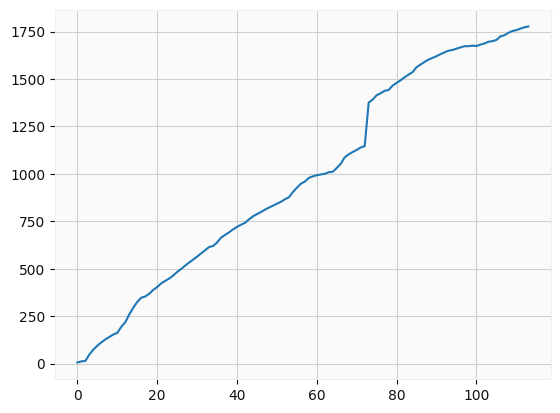

In [212]:
# plot the cumulative returns
import matplotlib.pyplot as plt
plt.plot(cumulative_returns)



Adding a new page to the dividennd dashboard that will load in data form the csv and parse the data from the closed trades, dividends paid 2021 to 2023.
For the clsed trades we have to we want to date closed, g/l and div earned columns. 

In [265]:
import pandas as pd
import numpy as np
import plotly.express as px

In [266]:
# read in the data from the excel file
closed_trades_df = pd.read_excel('./data/Dividend_Dashboard.xlsx', sheet_name='closed_trades')
div_paid_2023_df = pd.read_excel('./data/Dividend_Dashboard.xlsx', sheet_name='2023')
div_paid_2022_df = pd.read_excel('./data/Dividend_Dashboard.xlsx', sheet_name='2022')
div_paid_2021_df = pd.read_excel('./data/Dividend_Dashboard.xlsx', sheet_name='2021')

In [267]:
# keep Date and Amount columns
div_paid_2023_df = div_paid_2023_df[['Date', 'Amount']]
div_paid_2022_df = div_paid_2022_df[['Date', 'Amount']]
div_paid_2021_df = div_paid_2021_df[['Date', 'Amount']]

In [268]:
div_paid_2023_df.head()

,Date,Amount
0,2023-01-03,1.10
1,2023-01-03,0.79
2,2023-01-04,2.25
3,2023-01-06,2.50
4,2023-01-10,1.29


In [269]:
#  keep G/L, Div. Earned and Date Closed columns
closed_trades_df = closed_trades_df[['Date Closed','G/L ($)', 'Div. Earned']]
# change Nan to 0 in the Div. Earned column
closed_trades_df['Div. Earned'] = closed_trades_df['Div. Earned'].fillna(0)
closed_trades_df['Amount'] = closed_trades_df['G/L ($)'] - closed_trades_df['Div. Earned']
# drop the G/L ($) and Div. Earned columns
closed_trades_df = closed_trades_df[['Date Closed', 'Amount']]
# rename the columns
closed_trades_df = closed_trades_df.rename(columns={'Date Closed': 'Date'})
closed_trades_df.head()

,Date,Amount
0,2021-05-14,4.32
1,2021-06-11,5.67
2,2021-10-01,2.00
3,2022-02-16,28.77
4,2022-02-16,20.41


In [270]:
# concat the dataframes together
div_paid_df = pd.concat([div_paid_2023_df, div_paid_2022_df, div_paid_2021_df, closed_trades_df])
div_paid_df.head()

,Date,Amount
0,2023-01-03,1.10
1,2023-01-03,0.79
2,2023-01-04,2.25
3,2023-01-06,2.50
4,2023-01-10,1.29


In [271]:
# group by date and sum the amounts
div_paid_df = div_paid_df.groupby('Date').sum()
div_paid_df.head()

,Amount
Date,
2021-05-13,1.71
2021-05-14,4.32
2021-05-27,0.97
2021-06-11,5.67
2021-06-29,0.99


In [272]:
# using np.cumsum to calculate the cumulative sum of the values in the array
cumulative_div_paid = np.cumsum(div_paid_df['Amount'])

# create a new column and add cumulative_div_paid into div_paid_df dataframe
div_paid_df['cumulative_growth'] = cumulative_div_paid
# round the values in the dataframe
div_paid_df = div_paid_df.round(2)

div_paid_df

,Amount,cumulative_growth
Date,,
2021-05-13,1.71,1.71
2021-05-14,4.32,6.03
2021-05-27,0.97,7.00
2021-06-11,5.67,12.67
2021-06-29,0.99,13.66
...,...,...
2023-10-31,12.80,2484.84
2023-11-01,5.61,2490.45
2023-11-02,-8.39,2482.06


In [290]:
# create a plotly express line chart using plotys dark theme
fig = px.line(div_paid_df, x=div_paid_df.index , y='cumulative_growth',  title='Cumulative Growth Including Closed Trades and Dividends Paid', template='plotly_dark')
# center the title and increase the font size and use Rockwell font
fig.update_layout(title={'x':0.5, 'xanchor': 'center', 'font': {'size': 22, 'family': 'Rockwell'}})
# update the x and y axis labels
fig.update_layout(xaxis_title='', yaxis_title='Amount')
# add the dollar sign to the y axis
fig.update_yaxes(tickprefix="$")

fig.show()


In [274]:
# create a dataframe that is grouped by year and sum the amounts from the cumulative_div_paid column
div_paid_yearly_df = div_paid_df.groupby(pd.Grouper(freq='Y')).sum()
# keep only the year from the index
div_paid_yearly_df.index = div_paid_yearly_df.index.year
div_paid_yearly_df

,Amount,cumulative_growth
Date,,
2021,105.86,2383.42
2022,1614.50,142784.58
2023,798.47,340776.07


In [288]:
# create a bar chart using plotly express using plotys dark theme that shows the amount of dividends paid per year
fig = px.bar(div_paid_yearly_df, y='Amount',  title='Yearly Dividend Payouts:<br> A Snapshot of Annual Financial Growth', template='plotly_dark')
# center the title and increase the font size and use Rockwell font
fig.update_layout(title={'x':0.5, 'xanchor': 'center', 'font': {'size': 22, 'family': 'Rockwell'}})
# update the x and y axis labels
fig.update_layout(xaxis_title='', yaxis_title='Amount')
# add the dollar sign to the y axis
fig.update_yaxes(tickprefix="$")
# show only full years on xticks
fig.update_xaxes(tickmode='linear')

fig.show()